In [90]:
import matplotlib.pyplot as plt

import numpy as np
from scipy import integrate
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
from munch import Munch

## Kinetics simulations

E + S ⇌ ES ⇌ E + P

Rate constants are $k_\text{f}, k_\text{r}, k_\text{cat}$

In [91]:
Au_mol_per_cm_cubed = (19.3/196.96657)
Au_fmol_um3 = Au_mol_per_cm_cubed * 1e-15/1e-12
Ag_mol_per_cm_cubed = (10.49/107.8682)
Ag_fmol_um3 = Ag_mol_per_cm_cubed * 1e-15/1e-12

$$
\begin{align}
\frac{dT}{dt}& = \frac{k_\text{side} [\text{Ag}^+] A_\text{side}}{\rho A_\text{side} \sqrt{3}}   \\
\frac{dS}{dt}& = \frac{k_\text{top} [\text{Ag}^+] A_\text{top}}{\rho A_\text{top}}
\end{align}
$$

$$A_\text{top} = \frac{\sqrt{3}}{2}T^2$$

In [92]:
class NanoPrism:
    def __init__(self, Gface=5000, Gface_dagger=2500, k0=1e-3, K298=1e5, T=298, V=1, rho=Ag_fmol_um3):
        self.Gface = Gface
        self.Gface_dagger = Gface_dagger
        self.k0 = k0
        # k0 = Ag+ -> Ag rate...
        self.K298 = K298
        self.T=T
        self.k_top = self.k0
        self.k_face = self.k0*np.exp(-self.Gface_dagger/(8.3145*self.T)) # difference in free energy...
        self.rho = rho
        self.V=V
    
    def __call__(self, y, t):
        """State vector is [Ag⁺], top edge length, side edge length."""
        A_top = np.sqrt(3)/2*y[1]**2
        A_face = y[1]*y[2]*3 # Triangular prism
        rate_top = self.k_top * y[0] * A_top
        rate_face = self.k_face * y[0]* A_face
        rate_Ag = -(rate_top+rate_face)/self.V
        rate_side_edge = rate_top/(self.rho*A_top)
        rate_top_edge = rate_face/(self.rho*A_face*np.sqrt(3))
        return np.array([
            rate_Ag,
            rate_top_edge,
            rate_side_edge
        ])
    

class NanoSphere:
    def __init__(self, k0, V=1, rho=Au_fmol_um3):
        """Volume = 1 um³"""
        self.k0 = k0
        self.V = V
        self.rho= rho
    
    def __call__(self, y, t):
        """State vector is [AuCl₄], radius
        dn/rho = dV = 4*pi*r²*dr
        dn/(rho * 4*pi*r²) = dr
        """
        A = y[1]**2 * 4 * np.pi # um²
        rate = self.k0*A*y[0] # rate in fmol/s, y[0] in fmol/um³, A in um², k in 1/um-s
        
        return np.array([-rate/self.V,
                         rate/(self.rho * A)
        ])
    
    def rate(self, y):
        A = y[1]**2 * 4 * np.pi # um²
        return self.k0*A*y[0] # rate in fmol/s, y[0] in fmol/um³, A in um², k in 1/um-s


def prism(s, h, x_offset=0, y_offset=0, z_offset=0):
    pts = np.array([
        [0, 0, 0],
        [s/2, s*np.sqrt(3)/2, 0],
        [-s/2, s*np.sqrt(3)/2, 0],
        [0, 0, h],
        [-s/2, s*np.sqrt(3)/2, h],
        [s/2, s*np.sqrt(3)/2, h],
        ])
    x, y, z = pts.T
    x = x + x_offset
    y = y + y_offset
    z = z + z_offset
    ch = ConvexHull(pts)
    return Munch(x=x, y=y, z=z, triangles=ch.simplices, s=s, h=h, max_dim = max(s, h), offset=np.array([x_offset, y_offset, z_offset]))

M = mol/L = mol/dm³
mM = mmol/dm³
M = mmol/cm³
M = µmol/mm³
M = fmol/µm³

In [93]:
au = NanoSphere(2e-5, V=0.0001)
y0 = np.array([1e-3,0.002])
t = np.linspace(0, 600, 2001)
out = integrate.odeint(au, y0, t)

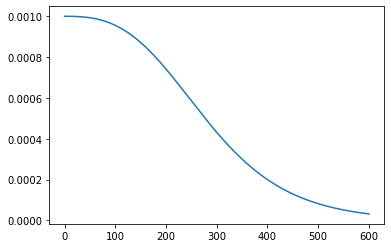

In [94]:
plt.plot(t, out[:, 0])

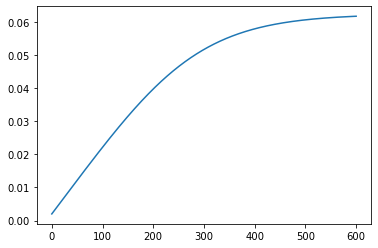

In [95]:
plt.plot(t, out[:, 1])

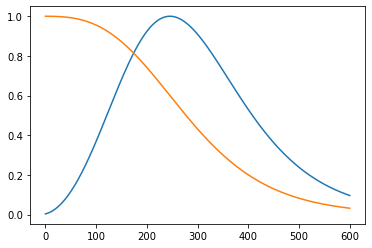

In [96]:
au_rate = au.rate(out.T)
plt.plot(t, au_rate/au_rate.max())
plt.plot(t, out[:, 0]/out[0, 0])

(-2.0, 38.0)

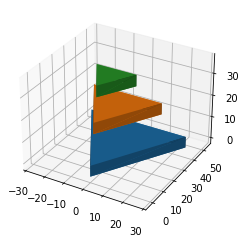

In [146]:
out = prism(5*10, 5, 0)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_trisurf(out.x, out.y, out.z, triangles=out.triangles, linewidth=0.2, antialiased=True)


out2 = prism(5*7, 5, y_offset=3, z_offset=18)
out3 = prism(5*4, 5, y_offset=6, z_offset=33)

ax.plot_trisurf(out2.x, out2.y, out2.z, triangles=out2.triangles, linewidth=1, antialiased=True, )
ax.plot_trisurf(out3.x, out3.y, out3.z, triangles=out3.triangles, linewidth=1, antialiased=True, )
ax.set_xlim3d(xmin=-30, xmax=30)
ax.set_ylim3d(ymin=-5, ymax=56)
ax.set_zlim3d(zmin=-2, zmax=38)

In [156]:
import plotly.figure_factory as ff

fig = ff.create_trisurf(x=out.x, y=out.y, z=out.z,
                         simplices=out.triangles,
                         title="Torus", aspectratio=dict(x=1, y=1, z=0.5), 
                       )


fig.show()

In [167]:
import pandas as pd
import plotly.express as px

fig = ff.create_trisurf(x=out.x, y=out.y, z=out.z,
                        simplices=out.triangles,
                        colormap=['rgb(0,176,246)', 'rgb(0,176,246)'], 
                        title="Mt Bruno Elevation", aspectratio=dict(x=1, y=1, z=0.5), 
                        showbackground=True, backgroundcolor="rgb(230, 230,230)", 
                        gridcolor="rgb(255, 255, 255)", 
                        zerolinecolor="rgb(255, 255, 255)")
def add_trisurf(fig, out):
    ff.create_trisurf(x=out.x, y=out.y, z=out.z,
                        simplices=out.triangles,
                        colormap=['rgb(0,176,246)', 'rgb(0,176,246)'], fig=fig)
    return fig

add_trisurf(fig, out2)
add_trisurf(fig, out3)



fig.update_layout(scene_zaxis_range=[-2, 35])
fig.show()

TypeError: create_trisurf() got an unexpected keyword argument 'fig'

In [ ]:
go.

In [ ]:
df

(-2.0, 38.0)

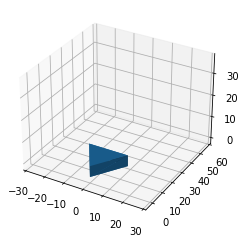

In [109]:

ax.set_xlim3d(xmin=-30, xmax=30)
ax.set_ylim3d(ymin=-5, ymax=60)
ax.set_zlim3d(zmin=-2, zmax=38)

## Nice nanoprism

In [81]:
np1 = NanoPrism(2e-5, V=0.0001)
y0_np1 = np.array([1e-3,0.001, 0.001]) # Starts at 1 nm on each axis
t1 = np.linspace(0, 600, 2001)
out = integrate.odeint(np1, y0_np1, t1)
sf = out[-1][1]
ef = out[-1][2]
Vf1 = (sf**2*np.sqrt(3)/4)*ef

(0.0, 40.0)

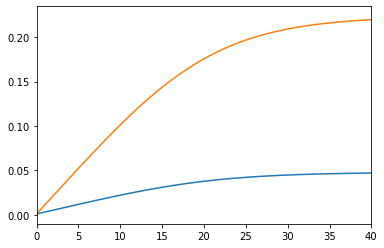

In [82]:
plt.plot(t1, out[:, 1])
plt.plot(t1, out[:, 2])
plt.xlim(0, 40)

In [83]:
np.exp(2500/(8.3145*298))

2.742834104953298

In [84]:
out[:, 2]/out[:, 1]

array([1.        , 2.47665556, 3.11903063, ..., 4.67231386, 4.67231386,
       4.67231386])

(0.0, 40.0)

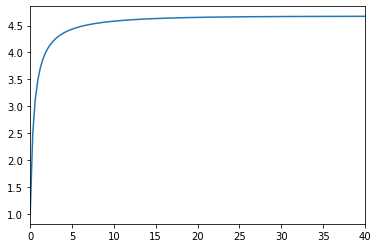

In [59]:
plt.plot(t1, out[:, 2]/out[:, 1])
plt.xlim(0, 40)

In [ ]:
np.exp(-)

In [37]:
def plot_prism(ax, prism):
    ax.plot_trisurf(prism.x, prism.y, prism.z, triangles=prism.triangles, linewidth=0.2, antialiased=True)

In [46]:
out[30, 1:]

array([0.02010903, 0.09178181])

In [47]:
p0 = prism(*y0_np1[1:], x_offset=0.05, y_offset=0.05)
pfinal = prism(*out[-1, 1:])
p1 = prism(*out[30, 1:], x_offset=0.05, y_offset=0.05)


(0.0, 0.2)

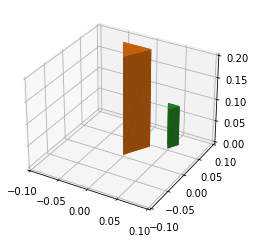

In [50]:
ax = plt.figure().add_subplot(projection='3d')
plot_prism(ax, p0)
plot_prism(ax, pfinal)
plot_prism(ax, p1)
ax.set_xlim3d(xmin=-0.1, xmax=0.1)
ax.set_ylim3d(ymin=-0.1, ymax=0.1)
ax.set_zlim3d(zmin=0, zmax=0.20)

In [86]:
np2 = NanoPrism(2e-5, V=0.0001)
y0_np2 = np.array([2e-3,0.001, 0.001]) # Starts at 1 nm on each axis
t2 = np.linspace(0, 600, 2001)
out2 = integrate.odeint(np2, y0_np2, t2)
sf = out2[-1][1]
ef = out2[-1][2]
Vf2 = (sf**2*np.sqrt(3)/4)*ef

In [89]:
Vf2/Vf1

1.9980046801764229

In [69]:
out2[-1, 1]/out2[-1, 2]

0.2132924452977128

In [ ]:
class Enzyme:
    def __init__(self, kf, kr, kcat):
        self.kf = kf
        self.kr = kr
        self.kcat = kcat
    
    def dydt(self, y, t):
        """State vector is S, E, ES, P"""
        kf, kr, kcat = self.kf, self.kr, self.kcat
        r1fwd = kf*y[0]*y[1]
        r1rev = kr * y[2]
        r2fwd = kcat * y[2]
        return np.array([
            -r1fwd + r1rev,
            -r1fwd + r1rev + r2fwd,
            r1fwd - r1rev - r2fwd,
            r2fwd
        ])
    
    def rate(self, y):
        return self.kcat * y.T[2]

In [ ]:
e = Enzyme(1, 1, 1)
y0 = np.array([1, 0.1, 0, 0])
t= np.linspace(0, 1000, 1001)
out = integrate.odeint(e.dydt, y0, t)

In [ ]:
out.shape
t.shape

In [ ]:
 e.rate(out)

In [ ]:
plt.plot(out[:, 0], e.rate(out), '.')